In [1]:
import sys
sys.path.append('..') 

from keithleyAPI import Communications
from tests_ import sensing_test,stability_test
import utils

In [2]:
import plotly.express as px 
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt
import os
import numpy as np

smu = Communications("TCPIP0::169.254.181.21::1225::SOCKET")
smu.connect()
smu._instrument_object.write_termination = "\0"
smu._instrument_object.read_termination = "\0"

In [3]:
DUT = 'd022024-I' # device under test
couple = 'r2c2'
VDL = 'CH1'
VDR = 'CH3'
CMN = 'CH2'

In [4]:
smu.query("BC") # clears all readings from buffer

'ACK'

# Diode connection Test

### To run a cell and go to the next one: Shift + enter
#### Run the following cell until it prints out "Device correctly stabilized"
Be sure to change the device under test on the last line

In [6]:
diode_df = []
mean_diff = []
TOT = 'DiodeConnected_StabilityforAptamerSensing-CT2' #type of test

### Run Stability Check before sensing test

Sweep #: 1
|VDL-VDR|:  0.0734
mean diff of diff L-R: nan
std diff of diff L-R: nan


C:\Users\Desi\anaconda3\envs\ada\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Desi\anaconda3\envs\ada\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Desi\anaconda3\envs\ada\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Desi\anaconda3\envs\ada\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Desi\anaconda3\envs\ada\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Sweep #: 2
|VDL-VDR|:  0.07523
mean diff of diff L-R: 0.00183
std diff of diff L-R: 0.0
Sweep #: 3
|VDL-VDR|:  0.07686
mean diff of diff L-R: 0.00173
std diff of diff L-R: 0.0001
Sweep #: 4
|VDL-VDR|:  0.07726
mean diff of diff L-R: 0.00129
std diff of diff L-R: 0.00063
Sweep #: 5


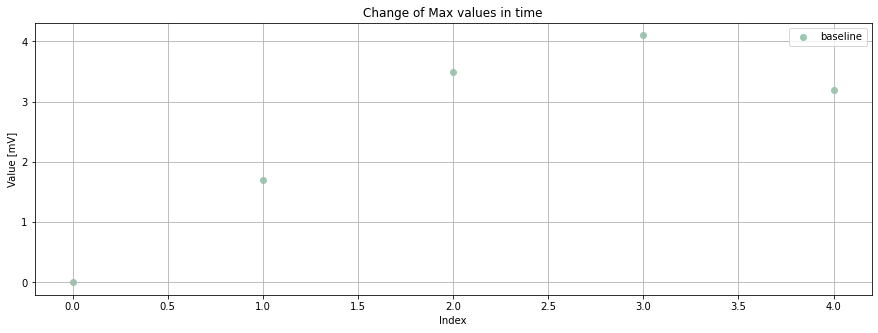

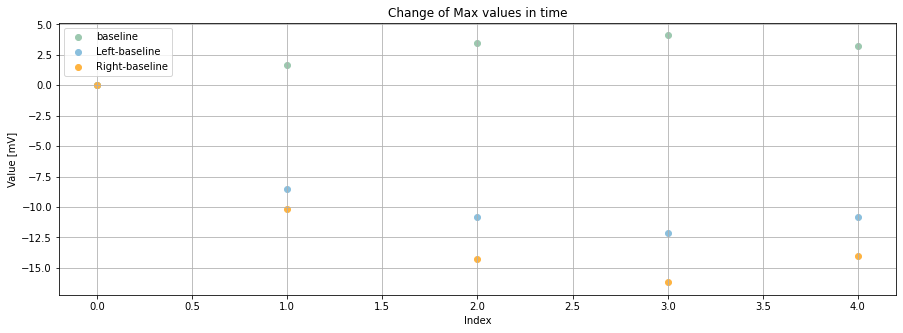

|VDL-VDR|:  0.07663
mean diff of diff L-R: 0.00112
std diff of diff L-R: 0.00062
Sweep #: 6
|VDL-VDR|:  0.07686
mean diff of diff L-R: 0.00096
std diff of diff L-R: 0.00064
Sweep #: 7
|VDL-VDR|:  0.0775
mean diff of diff L-R: 0.0009
std diff of diff L-R: 0.0006
Sweep #: 8
|VDL-VDR|:  0.0785
mean diff of diff L-R: 0.00092
std diff of diff L-R: 0.00056
std of the diff for last 8 0.00146
Sweep #: 9
|VDL-VDR|:  0.07813
mean diff of diff L-R: 0.00085
std diff of diff L-R: 0.00055
std of the diff for last 8 0.00094
Sweep #: 10


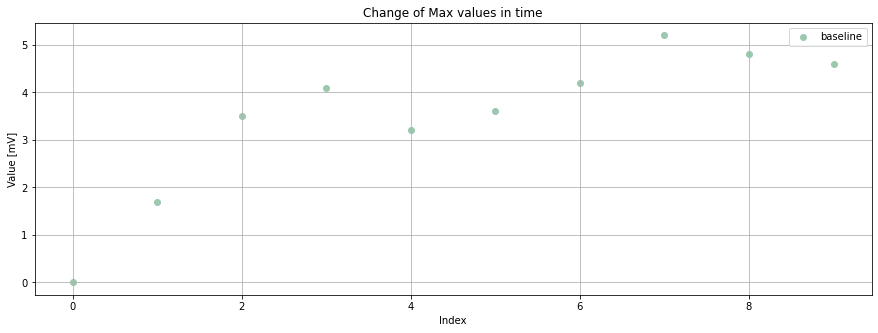

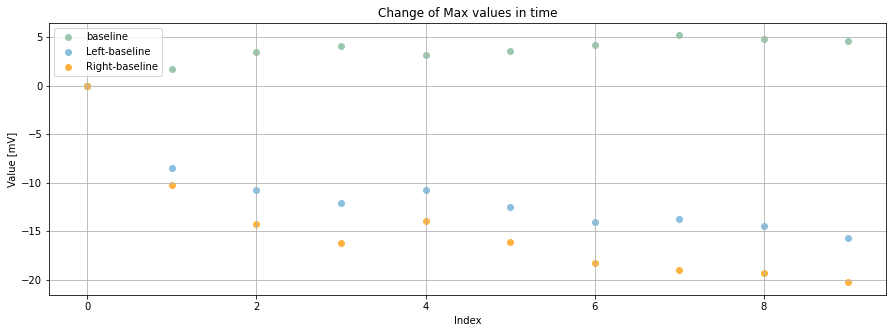

|VDL-VDR|:  0.07774
mean diff of diff L-R: 0.0008
std diff of diff L-R: 0.00054
std of the diff for last 8 0.00062
Sweep #: 11
|VDL-VDR|:  0.07685
mean diff of diff L-R: 0.00081
std diff of diff L-R: 0.00051
std of the diff for last 8 0.00062
Sweep #: 12
|VDL-VDR|:  0.07677
mean diff of diff L-R: 0.00076
std diff of diff L-R: 0.00051
std of the diff for last 8 0.00066
Sweep #: 13
|VDL-VDR|:  0.07675
mean diff of diff L-R: 0.00071
std diff of diff L-R: 0.00052
std of the diff for last 8 0.00064
Sweep #: 14
|VDL-VDR|:  0.07632
mean diff of diff L-R: 0.00069
std diff of diff L-R: 0.0005
std of the diff for last 8 0.00072
Sweep #: 15


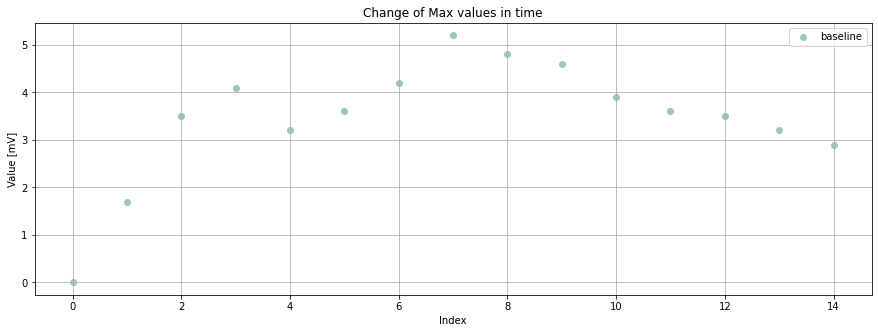

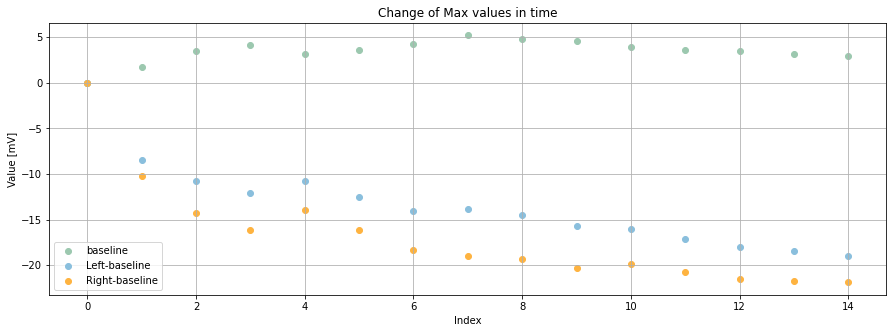

|VDL-VDR|:  0.07613
mean diff of diff L-R: 0.00065
std diff of diff L-R: 0.0005
std of the diff for last 8 0.00081
Sweep #: 16
|VDL-VDR|:  0.07636
mean diff of diff L-R: 0.00063
std diff of diff L-R: 0.00049
std of the diff for last 8 0.00066
Sweep #: 17
|VDL-VDR|:  0.0761
mean diff of diff L-R: 0.00061
std diff of diff L-R: 0.00048
std of the diff for last 8 0.0005
Sweep #: 18
|VDL-VDR|:  0.07568
mean diff of diff L-R: 0.0006
std diff of diff L-R: 0.00047
std of the diff for last 8 0.00038
0.000215624094200989
Device correctly stabilized
The directory doesn't exist
C:\Users\Desi\Desktop\TesiStanford\repo\WearS\Aptamer_Sensing\03042024-d022024-I-DiodeConnected_StabilityforAptamerSensing-CT2


In [7]:
 diode_df, mean_diff = stability_test('CH1', 'CH3', 'CH2', smu,diode_df,mean_diff,'sensing',couple,DUT,TOT,max_steps = 60)

In [20]:
utils.save_xls(diode_df, DUT+couple,TOT,additional_comment= 'r2c2-goodstabilizationBaseline', mode = 2)

The directory doesn't exist
C:\Users\Desi\Desktop\TesiStanford\repo\WearS\Aptamer_Sensing\03042024-d022024-Ir2c2-DiodeConnected_StabilityforAptamerSensing-CT


'03042024-d022024-Ir2c2-DiodeConnected_StabilityforAptamerSensing-CT'

#### Run the following cell to plot the max values in time for the last sweeps

In [ ]:
utils.plot_max_values(diode_df,['baseline'],couple,1,DUT,TOT,3,r'C:\Users\Desi\Desktop\TesiStanford\images-results')

#### Plot Diode Connection

In [ ]:
# plot DiodeConnection
fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

ax1.plot(diode_df[-1]['IDL'], diode_df[-1]['VDL'], color = 'blue', label = 'VDL')
ax1.set_ylabel('VdLeft [V]')
ax2.plot(diode_df[-1]['IDL'], diode_df[-1]['VDR'], color = 'red', label = 'VDR')
ax2.set_ylabel('VdRight [V]')
plt.grid()
ax1.set_xlabel('Id [A]')
plt.title('Diode Connected - Single Sweep')
ax1.legend()
ax2.legend(loc = 1)


# Sensing Test

### Run the following two cells only one time!

In [8]:
meandiff = []
stddiff = []
diode_dict_list = {} # dictionary where to store the list with the 20 sweeps of all the concentrations
diode_df_dict = {} # dictionary where to store the df with the 20 sweeps of all the concentrations
mean_std = [] #list where to store the mean and std of the òast 5 values of the last Nvalidsteps
mean_std_L = []
mean_std_R = []
baseline = 0

In [9]:
k = 0 # 10pM
conc = ['baseline','1pM','10pM','100pM','1nM','10nM','100nM','1uM']
#conc = ['1mM','2mM','4mM','8mM','16mM','32mM']

In [56]:
#conc = ['baseline','10mM','20mM','40mM','80mM','160mM','16mMK','32mMK']
#conc = ['1mM','2mM','4mM','8mM','10mMNa','16mM','20mMNa','32mM']
#conc = ['baseline','1pM_CT','1pM_S','10pM_CT','10pM_S','100pM_CT','100pM_S','1nM_CT','1nM_S','10nM_CT','10nM_S','100nM_CT','100nM_S','1uM_CT','1uM_S']
conc = ['baseline','1pM','10pM','100pM','1nM','10nM','100nM','1uM','1nM-MT','100nm_MT']

### Run all the following cells until 'END' every time you change concentration

In [ ]:
#baseline = 200 010324

In [57]:
TOT = 'DiodeConnected_SensingTest-CT' #Type Of Test
k, diode_df_dict, diode_dict_list, mean_std, mean_std_L, mean_std_R, folder, baseline = sensing_test('CH1', 'CH3', 'CH2', smu,k, conc, diode_df_dict, diode_dict_list, mean_std, mean_std_L, mean_std_R,DUT, TOT, couple, baseline)

Run #: 1
Run #: 2
Run #: 3
Run #: 4
Run #: 5
Run #: 6
Run #: 7
Run #: 8
Run #: 9
Run #: 10
Run #: 11
Run #: 12
Run #: 13
Run #: 14
Run #: 15
Run #: 16
Run #: 17
Run #: 18
Run #: 19
Run #: 20
The directory exists
C:\Users\Desi\Desktop\TesiStanford\repo\WearS\Aptamer_Sensing\03042024-d022024-I-DiodeConnected_SensingTest-CT
[[0.0, 0.0007192279811637581], [-0.0032433333333332925, 0.00041932485418028553], [-0.005693333333333328, 0.0002685764943797466], [-0.0065800000000000025, 0.0004196294661828213], [-0.00747333333333329, 0.000678920712111022], [-0.006949999999999998, 0.00028761471141480657], [-0.008113333333333306, 0.0003342653636459038], [-0.00891666666666667, 0.0006752201287152411], [-0.011453333333333288, 0.00020784609690826437], [-0.01152999999999997, 0.0006912227491112374]]


[[0.0, 0.0007192279811637581], [-0.0032433333333332925, 0.00041932485418028553], [-0.005693333333333328, 0.0002685764943797466], [-0.0065800000000000025, 0.0004196294661828213], [-0.00747333333333329, 0.000678920712111022], [-0.006949999999999998, 0.00028761471141480657], [-0.008113333333333306, 0.0003342653636459038], [-0.00891666666666667, 0.0006752201287152411], [-0.011453333333333288, 0.00020784609690826437], [-0.01152999999999997, 0.0006912227491112374]]


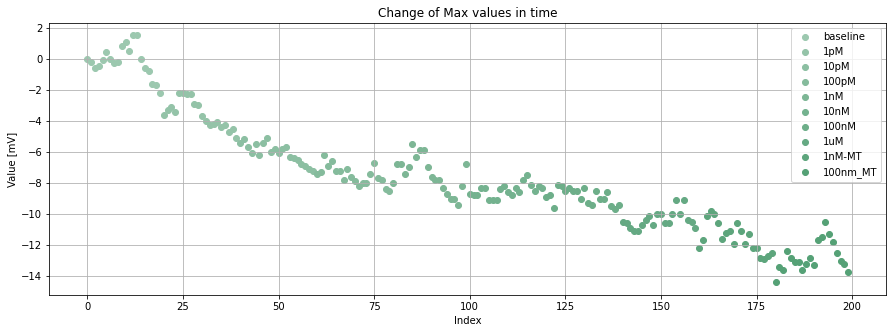

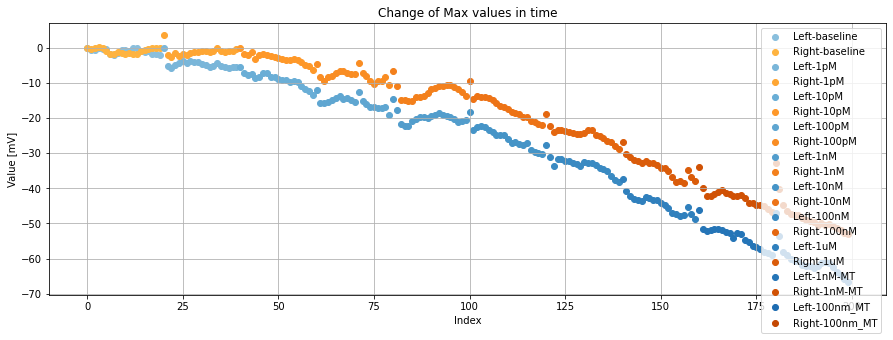

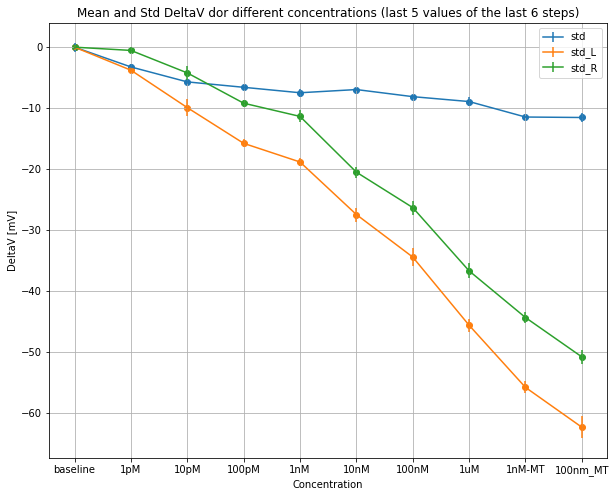

In [58]:
# printing the mean and the std of the last 5 values of the 20 sweeps. Each [] represents a concentration
print(mean_std)

# plotting change of MAx values in time for different concentrations
TOT = 'changeMaxDiffvaluesintime'
utils.plot_max_values(diode_df_dict,conc,couple,1,DUT,TOT, mode = 1)

# plotting change of Mx values in time for different concentrations for left and right electrodes
TOT = 'changeMaxDiffvaluesintime-LR'
utils.plot_max_values(diode_df_dict,conc,couple,1,DUT,TOT, mode = 2)

# plotting mean and std of the diff for different concentrations
utils.plot_mean_std(len(mean_std), mean_std_L,mean_std_R, mean_std, conc, couple, folder)

#### Interactive plot

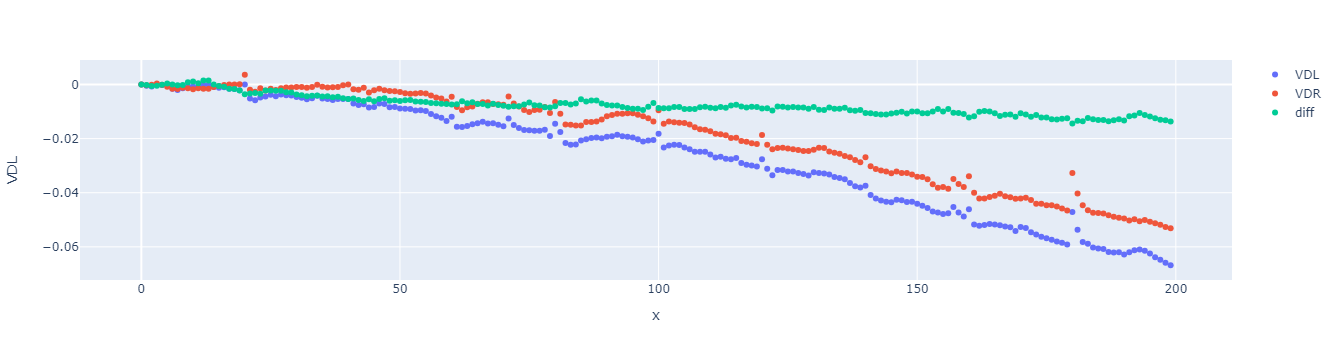

In [59]:
diff_in_time = pd.concat(diode_df_dict.values(), ignore_index=False)
numberoftests = len(diode_df_dict)
diff_in_time_grouped = diff_in_time.groupby(diff_in_time.index)
threshold = diff_in_time.index.max()

diff_in_time_max = [group for name, group in diff_in_time_grouped if name >= threshold]
fig = px.scatter(diff_in_time_max[0]-diff_in_time_max[0]['VDL'].iloc[0], x=range(len(diff_in_time_max[0])), y='VDL')
fig.data[0].name="VDL"
fig.update_traces(showlegend=True)
 
fig.add_scatter(x=np.array(range(len(diff_in_time_max[0]))), y=diff_in_time_max[0]['VDR']-diff_in_time_max[0]['VDR'].iloc[0], mode='markers',name = "VDR")
fig.add_scatter(x=np.array(range(len(diff_in_time_max[0]))), y=(diff_in_time_max[0]['VDL']-diff_in_time_max[0]['VDR'])-(diff_in_time_max[0]['VDL']-diff_in_time_max[0]['VDR']).iloc[0], mode='markers',name = "diff")
 
fig.show()

In [60]:
# std and mean only for the diff

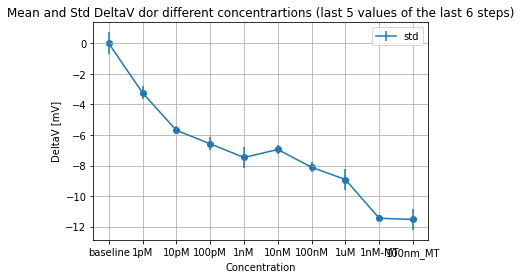

In [100]:
plt.scatter(conc[:k], [i[0]*1000 for i in mean_std] )
plt.errorbar(conc[:k], [i[0]*1000 for i in mean_std], yerr=[i[1]*1000 for i in mean_std], label='std')

plt.xlabel('Concentration')
plt.ylabel('DeltaV [mV]')
plt.title('Mean and Std DeltaV dor different concentrartions (last 5 values of the last 6 steps)')
plt.legend()
plt.grid()


In [62]:
mean_std

[[0.0, 0.0007192279811637581],
 [-0.0032433333333332925, 0.00041932485418028553],
 [-0.005693333333333328, 0.0002685764943797466],
 [-0.0065800000000000025, 0.0004196294661828213],
 [-0.00747333333333329, 0.000678920712111022],
 [-0.006949999999999998, 0.00028761471141480657],
 [-0.008113333333333306, 0.0003342653636459038],
 [-0.00891666666666667, 0.0006752201287152411],
 [-0.011453333333333288, 0.00020784609690826437],
 [-0.01152999999999997, 0.0006912227491112374]]

In [92]:
np.diff([i[0]-mean_std_L[0][0] for i in mean_std_L])

array([-0.00377667, -0.00613667, -0.00585333, -0.00306   , -0.00861667,
       -0.00697   , -0.01118   , -0.01018667, -0.00653   ])

In [93]:
np.diff([i[0]-mean_std_R[0][0] for i in mean_std_R])

array([-0.00053333, -0.00368667, -0.00496667, -0.00216667, -0.00914   ,
       -0.00580667, -0.01037667, -0.00765   , -0.00645333])

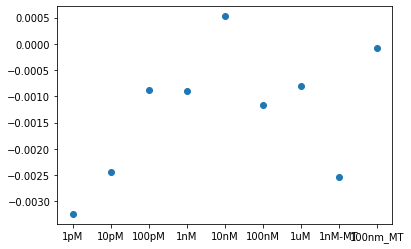

In [98]:
plt.scatter(conc[1:],np.diff([i[0] for i in mean_std_L])-np.diff([i[0]-mean_std_R[0][0] for i in mean_std_R]))

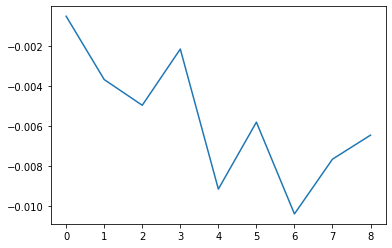

In [73]:
plt.plot(np.diff([i[0] for i in mean_std_R]))

In [71]:
[i[0] for i in mean_std_L]

[1.8691566666666666,
 1.8653799999999998,
 1.8592433333333334,
 1.8533899999999999,
 1.8503300000000003,
 1.8417133333333335,
 1.8347433333333334,
 1.8235633333333334,
 1.8133766666666664,
 1.8068466666666665]

In [74]:
np.diff([i[0] for i in mean_std_L])

array([-0.00377667, -0.00613667, -0.00585333, -0.00306   , -0.00861667,
       -0.00697   , -0.01118   , -0.01018667, -0.00653   ])